In [1]:
import h5py
import mne
import numpy as np
import pandas as pd

from mspca import mspca

In [2]:
# Severe=3,normal=0,Moderate=2,light=1
label=pd.read_csv('labels.csv')
label['labels'] = 0
for i in range(len(label)):
    valence = label.loc[i, 'valence']
    arousal = label.loc[i, 'Arousal']
    
    # Classify as 'Anxious' or 'Normal' first
    if valence <= 5 and arousal >= 5:
        # Within the 'Anxious' category, apply further classification
        if 0 < valence <= 2 and 7 <= arousal <= 9:
            label.loc[i, 'labels'] = 3
        elif 2 < valence <= 4 and 6 <= arousal < 7:
            label.loc[i, 'labels'] = 2
        elif 4 < valence <= 5 and 5 <= arousal < 6:
            label.loc[i, 'labels'] = 1

labels = pd.DataFrame(pd.concat([label['labels']]*2).sort_index(kind='merge'))
print(labels['labels'].value_counts())



labels
0    156
3     90
1     20
2     10
Name: count, dtype: int64


In [3]:
file_path = './Preprocessed_data(mat)/S01preprocessed.mat'
with h5py.File(file_path, 'r') as file:
    first_key = list(file.keys())[0]
    data = np.array(file[first_key])
    data=data*1e-6

In [4]:
saved=[]
for i in range(len(data)):
    saved.append((data[i],np.array(label['labels'])[i]))


In [5]:
sfreq = 128  # Placeholder for the actual sampling frequency
ch_names = ['AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4',]
data=data.reshape(12,14,1920)
# Create an MNE Info object
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
montage = mne.channels.make_standard_montage('standard_1020')

# Initialize an empty list to store the filtered data arrays
filtered_data = []

# Define the band-pass filter parameters
l_freq = 1.0  # Low frequency cutoff for the band-pass filter
h_freq = 40.0  # High frequency cutoff for the band-pass filter

# Apply band-pass filter to each chunk and store the filtered data
for i in range(data.shape[0]):  # Loop through the chunks
    # Create a RawArray object for the current chunk
    raw = mne.io.RawArray(data[i, :, :], info)  # Data should be transposed to match MNE structure

    # Apply the band-pass filter
    raw.filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin')

    # Append the filtered data to our list
    filtered_data.append(raw.get_data())

# Convert the list of filtered data arrays to a numpy array if necessary
filtered_data = np.array(filtered_data)
raw.set_montage(montage)

Creating RawArray with float64 data, n_channels=14, n_times=1920
    Range : 0 ... 1919 =      0.000 ...    14.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Creating RawArray with float64 data, n_channels=14, n_times=1920
    Range : 0 ... 1919 =      0.000 ...    14.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass 

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,17 points
Good channels,14 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,128.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [6]:
selected_channel=['F7','F8']
raw.pick_channels(selected_channel)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,17 points
Good channels,2 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,128.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


Fitting ICA to data using 2 channels (please be patient, this may take a while)
Selecting by number: 2 components
Fitting ICA took 0.1s.


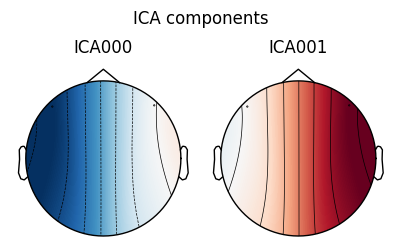

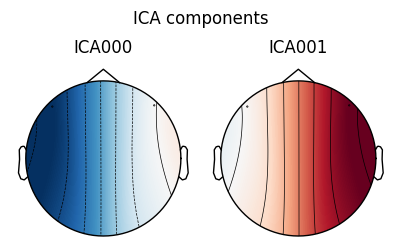

In [7]:
ica=mne.preprocessing.ICA(n_components=2,random_state=0)
ica.fit(raw.copy())
ica.plot_components(outlines='head')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 15.000 (s)


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


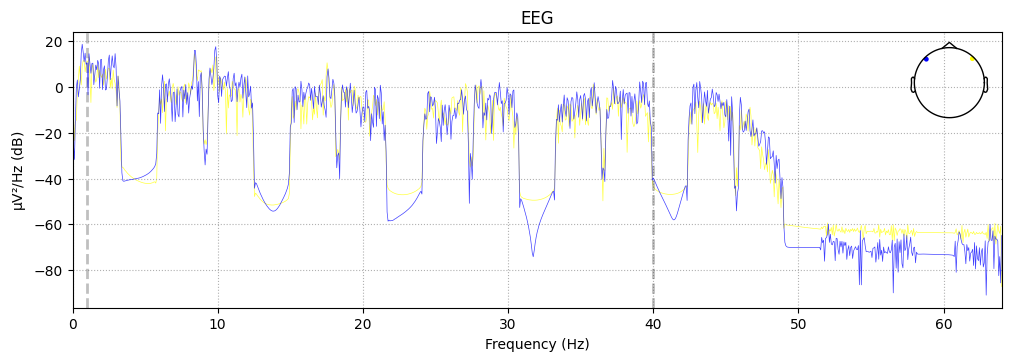

In [8]:
raw.plot_psd()

In [9]:
ica.exclude=[0]
raw_cleaned = raw.copy()
new_raw=ica.apply(raw_cleaned,exclude=ica.exclude)

Applying ICA to Raw instance
    Transforming to ICA space (2 components)
    Zeroing out 1 ICA component
    Projecting back using 2 PCA components


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 15.000 (s)


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


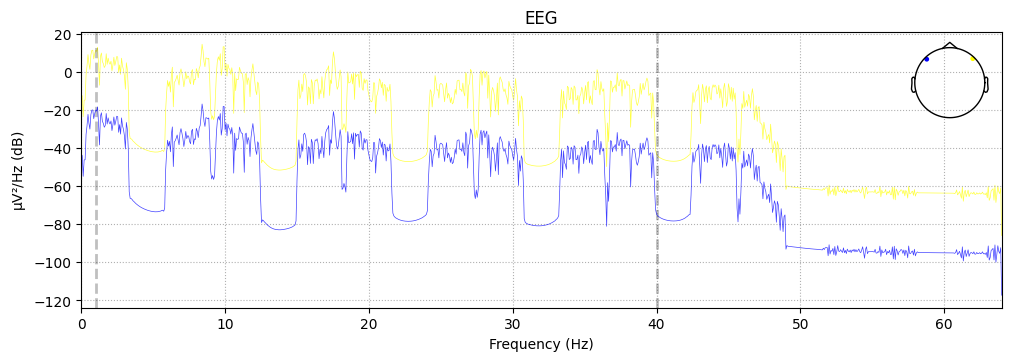

In [10]:
new_raw.pick_channels(selected_channel).plot_psd()